# Lab 7: Deep Learning for Sequence Processing

This lab introduces deep neural networks for processing sequential data, such as text, using recurrent neural networks. It will show you how to construct, train and test deep neural networks for text classification and sequence labelling using Pytorch. This builds on the simpler neural network from last week and applies deep learning to some of the datasets we worked with in earlier labs.


### Aims
* Learn how to construct a deep neural network with Pytorch.
* Try out LSTMs for processing sequences of tokens.
* Understand how to format the text data and use word embeddings as input to the network.
* Learn how to train the model and use it to make predictions on a test set.
* Apply the model to some of our previous tasks: sentiment classification (lab 2) and named entity recognition (lab 6). 

### Outline

* (Re-)loading sentiment classification corpus (movie reviews).
* Constructing a deep text classifier using a Bi-LSTM with feed-forward layers on top.
* Training and test the text classifier on sentiment classification.
* Using word embeddings as inputs instead of one-hot encodings.
* (Re-)loading the re3d corpus (defence & security news). 
* Construct a sequence tagger using a Bi-LSTM.
* Training and testing the sequence tagger on the NER task.

### How To Complete This Lab

Read the text and the code then look for 'TODOs' that instruct you to complete some missing code or answer a question. You don't have to stick rigidly to the lab -- feel free to explore other methods and data to help you understand what's going on or to go beyond this lab. 

Aim to work through the lab during the scheduled lab hour. You can also contact TAs with questions at the scheduled times throughout the week, or post your questions to our Teams conversation.

The labs *will not be marked*. However, they will prepare you for the coursework, so try to keep up with the weekly labs and have fun with the exercises!

### More Information

Please see [chapter 9](https://web.stanford.edu/~jurafsky/slp3/9.pdf) of the Jurafsky and Martin book for more on this topic. 

Pytorch Tutorial: https://pytorch.org/tutorials/


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

import nltk

from sklearn.model_selection import train_test_split

import torch

%load_ext autoreload
%autoreload 2

# 1 Movie Review Classification

In Lab 2 we managed to build a Naïve Bayes classifier. Can we build a classifier with a neural network (NN)? In this section, we will create a Bi-LSTM classifier that performs the sentiment analysis for the movie reviews by using PyTorch.

Let's start by loading the movie review.

In [2]:
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split

categories = movie_reviews.categories()
# Get the data into a list, where each entry is a document tuple consisting of a list of tokens and a category label
data = [
        (list(movie_reviews.words(fileid)), category) 
        for category in categories
        for fileid in movie_reviews.fileids(category)
       ]

Like Naïve Bayes classifier, we need to construct a dictionary from the dataset, which will be our set of features.

In [3]:
from nltk import FreqDist

docs = [doc for doc, label in data]
labels = [label for doc, label in data]

words = []
for doc in docs:
    words += doc
    
wordfreqs = FreqDist(words)
vocabulary = list(wordfreqs.keys())
print(len(vocabulary))

39768


Then we use the train_test_split method from scikit learn to split the data into training, development, and test set as the given portions below.

In [4]:
test_size = 0.2
dev_size = 0.2
train_size = 1 - test_size - dev_size

# First split the test set from the train+dev data
train_dev_data, test_data = train_test_split(data, train_size=train_size+dev_size, test_size=test_size)

# Split the train data from the dev data
train_data, dev_data = train_test_split(train_dev_data, train_size=(train_size)/(train_size + dev_size) , test_size=(dev_size)/(train_size + dev_size))
print(len(train_data), len(dev_data), len(test_data))

1200 400 400


Before we start pre-processing our data, we separate them into reviews and labels.

In [5]:
train_docs = [doc for doc, label in train_data]
train_labels = [label for doc, label in train_data]

Usually, a NN is constructed with 3 layers: input layer (embedding layer), hidden layer (CNN, RNN, etc.), output layer (full connected layer).

To pass out data into the input layer, we first need to transfer the text data to numerical data so that we can embed it with the embedding layer. The easiest way to do so is create a dictionary that map the vocabularies into integer. e.g. {'hello':1, 'world':2}

In [6]:
def doc_encoding(docs, vocabulary):
    
    # create word to id dictionary
    word_to_id = {w:i+1 for i,w in enumerate(vocabulary)}
    # convert docs to token-id lists
    encode_docs = [[word_to_id[word] for word in tokens_doc] for tokens_doc in docs]

    return encode_docs

train_doc_encode = doc_encoding(train_docs, vocabulary)
train_doc_encode[0]

[1474,
 2609,
 55,
 1517,
 2537,
 11,
 39,
 877,
 418,
 82,
 808,
 13,
 6004,
 16,
 39,
 33,
 68,
 2728,
 317,
 319,
 4351,
 754,
 11,
 62,
 39,
 40,
 39,
 877,
 418,
 82,
 808,
 13,
 16389,
 9301,
 2390,
 6004,
 39,
 566,
 11,
 130,
 4351,
 2932,
 202,
 23,
 99,
 13,
 9286,
 33,
 1741,
 513,
 1137,
 5058,
 196,
 24,
 131,
 16,
 24,
 163,
 927,
 33,
 291,
 2726,
 11,
 336,
 205,
 31,
 808,
 7558,
 139,
 8,
 6765,
 3298,
 11,
 65,
 66,
 537,
 3543,
 208,
 16390,
 16,
 1990,
 16,
 7853,
 3623,
 86,
 3567,
 91,
 1180,
 8,
 16389,
 9301,
 360,
 86,
 24,
 39,
 16391,
 39,
 16392,
 91,
 11,
 464,
 11,
 65,
 66,
 7232,
 7,
 1266,
 97,
 16390,
 16,
 24,
 360,
 166,
 62,
 39,
 40,
 3047,
 11,
 24,
 16390,
 97,
 1986,
 11,
 13,
 24,
 1179,
 66,
 695,
 16,
 39,
 457,
 329,
 1371,
 39,
 551,
 57,
 24,
 545,
 11,
 13,
 205,
 2939,
 55,
 24,
 16391,
 16392,
 66,
 138,
 11,
 6771,
 603,
 333,
 11,
 13,
 2506,
 7,
 1266,
 16,
 24,
 6268,
 57,
 68,
 360,
 11,
 464,
 11,
 66,
 55,
 62,
 592,
 4351,
 62,

As we can see, the each word in the document is now encoded with given interger.

Next, let's do the same for the labels. Label the `'pos'` as `1` and `'neg'` as `0`

In [7]:
def label_encoding(labels):
    
    encode_label = [1 if label =='pos' else 0 for label in labels] 
    
    return np.array(encode_label)

train_label_encode = label_encoding(train_labels)
train_label_encode[:10]

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 0])

It is more efficient to process multiple sequences (documents) a batch of data than one-by-one. However, this requires that the sequences all have the same size. Thus, we need to pad/truncate the reviews into the same length. The RNN will ignore the special pad tokens. Let's plot a histogram to understand the length distribution of reviews.

Mean of the document length: 791.91
Median of the document length: 745.0


(array([ 76., 509., 763., 415., 140.,  56.,  25.,  12.,   1.,   3.]),
 array([  19.,  305.,  591.,  877., 1163., 1449., 1735., 2021., 2307.,
        2593., 2879.]),
 <a list of 10 Patch objects>)

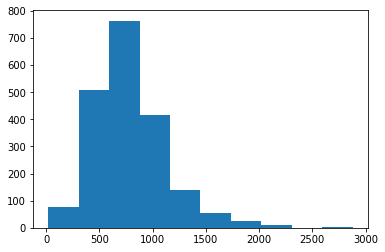

In [8]:
import statistics

rv_l = [len(d) for d in docs]
print('Mean of the document length: {}'.format(statistics.mean(rv_l)))
print('Median of the document length: {}'.format(statistics.median(rv_l)))

plt.hist(rv_l)

As most of the reviews are less than 800 words, the sequence length will be 800.

Note that, for RNN/LSTM, the network is more likely to remember the input at the end of the sequence. While padding, we add `0` at the beginning of the sequence instead of the end.

**TODO 1.1:** Write a function that pads or truncates the data to a given sequence length. The first argument, doc_encode, is a list where each entry corresponds to a document, represented as a list of tokens.

In [9]:
def pad_text(doc_encode, seq_length):
    ###WRITE YOUR OWN CODE HERE
    reviews = []
    for doc in doc_encode:
        if len(doc) >= seq_length:
            reviews.append(doc[:seq_length])
        else:
            reviews.append([0]*(seq_length-len(doc)) + doc)
        
    return np.array(reviews)

sequence_length = 1000  # truncate all docs longer than this. Padd all docs shorter than this.
train_padded_doc = pad_text(train_doc_encode, seq_length=sequence_length)
train_padded_doc[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In Pytorch, NN takes tensor, a multi-dimensional matrix containing elements of a single data type, as the input. Then a `Dataloader` is built to separate the dataset into smaller batches and suffer them.

Note that for numpy array, we need to apply `torch.from_numpy()` method to transfer it into a tensor while building the dataset.

TensorDataset: http://man.hubwiz.com/docset/PyTorch.docset/Contents/Resources/Documents/data.html
DataLoader: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [40]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 100

train_tensor = TensorDataset(torch.from_numpy(train_padded_doc), torch.from_numpy(train_label_encode))
train_loader = DataLoader(train_tensor, batch_size = batch_size, shuffle = True)


Let's process the development and test set as well.

In [41]:
dev_docs = [doc for doc, label in dev_data]
dev_labels = [label for doc, label in dev_data]
dev_doc_encode = doc_encoding(dev_docs, vocabulary)
dev_label_encode = label_encoding(dev_labels)
dev_padded_doc = pad_text(dev_doc_encode, sequence_length)
dev_tensor = TensorDataset(torch.from_numpy(dev_padded_doc), torch.from_numpy(dev_label_encode))
dev_loader = DataLoader(dev_tensor, batch_size = batch_size, shuffle = True)

test_docs = [doc for doc, label in test_data]
test_labels = [label for doc, label in test_data]
test_doc_encode = doc_encoding(test_docs, vocabulary)
test_label_encode = label_encoding(test_labels)
test_padded_doc = pad_text(test_doc_encode, sequence_length)
test_tensor = TensorDataset(torch.from_numpy(test_padded_doc), torch.from_numpy(test_label_encode))
test_loader = DataLoader(test_tensor, batch_size = batch_size, shuffle = True)

After processing the data, now it's time for us to build the network!

For movie review classification, we intend to build a NN with three different layers. 
### Embedding layer
In the embedding layer, the network will create embeddings for the index with a given embedding dimension. The module `nn.Embedding()` creates a simple lookup table that stores embeddings of a fixed dictionary and size. This module is often used to store word embeddings and retrieve them using indices. The module's input is a list of indices, and the output is the corresponding word embeddings.

https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
### BiLSTM layers
Pytorch provides a `nn.LSTM()` module for applying a multi-layer LSTM to an input sequence. With this module, you can also build the BiLSTM we need for this lab. Please check the documentation to see how to construct the object as a bidirectional layer.

Note that for BiLSTM, the output size has `2*hidden_units`. Becasue the output comes from both directions.

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
### Full connected layer
Fully Connected layers in a neural network are those layers where all the inputs from one layer are connected to every activation unit of the next layer. In classification task, a full connected layer aims to map the output from the hidden layer to the number of class. Then a logistic function can be implemented to determine the class. Here we will use `nn.Linear()` to build a linear layer to reduce the LSTM output dimensions.

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

**TODO 1.2:** Construct the NN with three layers, and develop the forward function that feedforward the input data and generate an output in `(batch_size, n_class)` dimension.

**Hint:** The following code is a basic DNN class that contains an init function and a feedforward function. What you need to do is modifying the hidden layer into a BiLSTM.

In [46]:
from torch import nn

class BiLSTM(nn.Module):
    
    def __init__(self, n_vocab, n_embed, n_hidden, n_layers, n_class):
        super(BiLSTM, self).__init__()
        
        ###WRITE YOUR OWN CODE HERE:  
        self.embedding = nn.Embedding(n_vocab, n_embed) # embedding layer
#         self.layer = nn.Linear(n_embed, n_hidden) # Hidden layer
#         self.activation = nn.Sigmoid() # Hidden layer
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, bidirectional=True) # BiLSTM layer
        self.fc = nn.Linear(n_hidden*2, n_class) # Full connection layer
        
        
    def forward (self, input_words):
        ###WRITE YOUR OWN CODE HERE
                                                        # INPUT   :  (batch_size, seq_length)
        embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
#         linear_out = self.layer(embedded_words)         # (batch_size, seq_length, n_hidden)
#         linear_out = self.activation(linear_out)        # (batch_size, seq_length, n_hidden)
#         linear_out = linear_out[:,-1,:]                 # (batch_size, 2*n_hidden)
        lstm_out, matrix = self.lstm(embedded_words)    # (batch_size, seq_length, 2*n_hidden)
        lstm_out = lstm_out[:,-1,:]                     # (batch_size, 2*n_hidden)
        fc_out = self.fc(lstm_out)                      # (batch_size, n_class)

        return fc_out


**TODO 1.3:** Create a NN with the BiLSTM class we wrote. 

**Hint:** `model = BiLSTM(...)`

In [47]:
n_vocab = len(vocabulary)
n_embed = 100  # number of dimension for embeddings
n_hidden = 64 # number of hidden unit for BiLSTM
n_layers = 1   # number of BiLSTM layer
n_output = 2   # 1 ("pos") and 0 ("neg")

###WRITE YOUR OWN CODE HERE
model = BiLSTM(n_vocab, n_embed, n_hidden, n_layers, n_output)

After desigining our network, we need to create a train function to calculate the loss for each input and perform backpropagation to optimise the network. During training, the weights of all the layer will be updated.

We build a training function to train the NN with given epoches. The function also prints the performance of both training and development set during the training.

**TODO 1.4:** Following the training, complete the validation part in the function. So that it can evaluate network with the development data.

In [48]:
def train_nn(epoch, model, train_data, dev_data, loss_fn, optimizer):
    
    for e in range(epoch):
        train_correct = 0
        dev_correct = 0
        train_size = 0
        dev_size = 0
        
        model.train()
        train_losses = []
        
        for inputs, labels in train_data:
            optimizer.zero_grad()
            output = model(inputs)
            loss = loss_fn(output, labels)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(output, 1)
            correct = torch.sum(predicted == labels).item()
            train_correct += correct
            train_size += torch.numel(labels)
            
        train_accuracy = train_correct/train_size*100
            
        model.eval()
        dev_losses = []

        for dev_inputs, dev_labels in dev_data:
            ###WRITE YOUR OWN CODE HERE
            dev_output = model(dev_inputs)
            dev_loss = loss_fn(dev_output, dev_labels)
            dev_losses.append(dev_loss.item())
            _, predicted = torch.max(dev_output, 1)
            correct = torch.sum(predicted == dev_labels).item()
            dev_correct += correct
            dev_size += torch.numel(dev_labels)
            
        dev_accuracy = dev_correct/dev_size*100
        
        print("Epoch: {}/{}".format((e+1), epoch),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Training Accuracy: {:.4f}%".format(train_accuracy),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))
    return model


The last step before we start training is defining the loss function and optimizer.

Here we use cross-entropy loss and Adam optimization. Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. The module `nn.CrossEntropyLoss()` combines `LogSoftmax` and `NLLLoss` in one single class so that we don't have to implement an extra softmax layer.

Cross Entropy Loss: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

Adam optimization: https://pytorch.org/docs/stable/optim.html

**TODO 1.5:** Define the loss function and optimizer. And train the network.

In [ ]:
from torch import optim

learning_rate = 0.0005

###WRITE YOUR OWN CODE HERE
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch = 5  # train loss << validation loss from ~ epoch 3 or 4
trained_model = train_nn(epoch, model, train_loader, dev_loader, loss_fn, optimizer)

Epoch: 1/5 Training Loss: 0.6975 Validation Loss: 0.6977 Training Accuracy: 50.2500% Validation Accuracy: 48.7500%
Epoch: 2/5 Training Loss: 0.6889 Validation Loss: 0.6971 Training Accuracy: 54.2500% Validation Accuracy: 49.5000%
Epoch: 3/5 Training Loss: 0.6826 Validation Loss: 0.6973 Training Accuracy: 56.8333% Validation Accuracy: 49.7500%


**TODO 1.6:** Evaluate the model on test set. Complete the code to count the correct classifications.

In [16]:
trained_model.eval()

test_losses = []
correct = 0  # count the number of correct classification labels

for inputs, labels in test_loader:
    test_output = trained_model(inputs)
    loss = loss_fn(test_output, labels)
    test_losses.append(loss.item())
    _, predicted = torch.max(test_output, 1)
    
    ###WRITE YOUR OWN CODE HERE
    c = torch.sum(predicted == labels).item()
    correct += c
    
accuracy = correct/len(test_loader.dataset)*100

print("Test Accuracy: {:.2f}%".format(accuracy))
# print(predicted)

Test Accuracy: 57.50%


Now let's use word embeddings as inputs instead of one-hot encodings.

As in lab 4, let's train a word2vec embedding with the movie reviews.

In [17]:
from gensim.models import word2vec

# create gensim model as in lab 4
sentences = []
for category in categories:
    for fileid in movie_reviews.fileids(category):
        sentences.extend(movie_reviews.sents(fileid))

w2v = word2vec.Word2Vec(sentences, sg=1, min_count=1, window=3, size=n_embed)

weights = w2v.wv.vectors
len(w2v.wv.vocab)

39768

**TODO 1.7:** Modify the embedding layer of the BiLSTM class by adding word2vec weights with `nn.Embedding.from_pretrained()`.

**Hint:** The weights for all the layers will be updated during. However, as we applied a trained embedding methods we don't want the weights of embedding layer updated during training.

In [18]:
class W2VBiLSTM(nn.Module):
    
    def __init__(self, n_embed, n_hidden, n_layers, n_class, weights):
        super(W2VBiLSTM, self).__init__()
        
        weights = torch.FloatTensor(weights) 
        
        ###WRITE YOUR OWN CODE HERE
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.embedding.requires_grad = False
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, bidirectional=True) # BiLSTM layer
        self.fc = nn.Linear(n_hidden*2, n_class) # Full connection layer
        
        
    def forward (self, input_words):
        ###WRITE YOUR OWN CODE HERE
                                                        # INPUT   :  (batch_size, seq_length)
        embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
        lstm_out, matrix = self.lstm(embedded_words)    # (batch_size, seq_length, 2*n_hidden)
        lstm_out = lstm_out[:,-1,:]                     # (batch_size, 2*n_hidden)
        fc_out = self.fc(lstm_out)                      # (batch_size, n_class)

        return fc_out

**TODO 1.8:** Create the model, initialise the loss function and optimizer, and train the network.

In [19]:
epoch = 5

###WRITE YOUR OWN CODE HERE
w2v_model = W2VBiLSTM(n_embed, n_hidden, n_layers, n_output, weights)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(w2v_model.parameters(), lr=0.001)

w2v_model = train_nn(epoch, w2v_model, train_loader, dev_loader, loss_fn, optimizer)

Epoch: 1/5 Training Loss: 0.6925 Validation Loss: 0.6915 Training Accuracy: 53.2500% Validation Accuracy: 51.5000%
Epoch: 2/5 Training Loss: 0.6883 Validation Loss: 0.6897 Training Accuracy: 53.0833% Validation Accuracy: 54.0000%
Epoch: 3/5 Training Loss: 0.6856 Validation Loss: 0.6905 Training Accuracy: 54.1667% Validation Accuracy: 53.0000%
Epoch: 4/5 Training Loss: 0.6808 Validation Loss: 0.6895 Training Accuracy: 56.0000% Validation Accuracy: 52.2500%
Epoch: 5/5 Training Loss: 0.6776 Validation Loss: 0.6916 Training Accuracy: 56.7500% Validation Accuracy: 52.0000%


**TODO 1.9:** Evaluate the test set.

In [20]:
w2v_model.eval()

###WRITE YOUR OWN CODE HERE
test_losses = []
correct = 0

for inputs, labels in test_loader:
    test_output = trained_model(inputs)
    loss = loss_fn(test_output, labels)
    test_losses.append(loss.item())
    _, predicted = torch.max(test_output, 1)
    c = torch.sum(predicted == labels).item()
    correct += c
    
accuracy = correct/len(test_loader.dataset)*100

print("Test Accuracy: {:.2f}%".format(accuracy))
# print(predicted)

Test Accuracy: 57.50%


# 2 Named Entity Recognition (Optional)

In this section, we will construct a sequence tagger using a Bi-LSTM. The most significant difference between NER and sentiment classification is that in NER, we take the output from every time steps to the output layer for classification. However, in sentiment classification, we only used the last time step.

As in lab 6, let's start by loading the re3d dataset.

In [21]:
from lab6_data.load_re3d import load_re3d_data

sentences, tags, tag_names_to_idx, tag_idx_to_names, relation_pairs = load_re3d_data()

Found 98 documents
Loaded 2433 non-overlapping entities in total.
We have loaded a dataset with 953 sentences.


Then we separate the data into training and test set. Comparing to lab 6, we only keep the taggers and remove the relationship.

In [22]:
data = []
for i in range(len(sentences)):
    tagged_words = list(sentences[i]), list(tag_idx_to_names[tags[i]])
    data.append(list(tagged_words))

train_set, test_set = train_test_split(
    data,
    train_size=0.80,
    test_size=0.20,
    random_state=101
)

train_sentences, train_labels = zip(*train_set)
test_sentences, test_labels = zip(*test_set)
print(f'Number of training sentences: {len(train_sentences)}')
print(f'Number of test sentences: {len(test_sentences)}')

Number of training sentences: 762
Number of test sentences: 191


Here are some examples of the sentences and the tags.

In [23]:
print('Sentence example: {}'.format(train_sentences[0]))
print(f'Tag example: {train_labels[:10]}')

Sentence example: ['We', 'will', 'continue', 'to', 'strike', 'ISIL', 'military', 'targets', 'in', 'support', 'of', 'our', 'partners', 'in', 'order', 'to', 'defeat', 'ISIL', 'in', 'Iraq', '.']
Tag example: (['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Organisation', 'I-Organisation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Organisation', 'I-Organisation', 'I-Organisation', 'I-Organisation', 'I-Organisation', 'I-Organisation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Organisation', 'I-Organisation', 'I-Organisation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Organisation', 'I-Organisation', 'I-Organisation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-

Similar to the previous task, a dictionary of the words is required as input features.

In [24]:
from nltk import FreqDist

words = []
for s in sentences:
    words.extend(s)
wordfreqs = FreqDist(words)
vocabulary_ner = list(wordfreqs.keys())
print(len(vocabulary_ner))

4381


For tags, we add one more feature `'PAD'` that represents the paddings for the sentences.

In [25]:
tag_names_to_idx = {t:i+1 for t,i in tag_names_to_idx.items()}
tag_names_to_idx['PAD'] = 0
print('Number of tags: {}'.format(len(tag_names_to_idx)))
print(tag_names_to_idx)

Number of tags: 32
{'O': 1, 'B-DocumentReference': 2, 'B-Frequency': 3, 'B-Coordinate': 4, 'B-Location': 4, 'B-MilitaryPlatform': 5, 'B-Money': 6, 'B-Nationality': 7, 'B-Organisation': 8, 'B-Person': 9, 'B-Quantity': 10, 'B-Temporal': 11, 'B-Url': 12, 'B-Vehicle': 13, 'B-Weapon': 14, 'B-CommsIdentifier': 15, 'I-DocumentReference': 16, 'I-Frequency': 17, 'I-Coordinate': 18, 'I-Location': 18, 'I-MilitaryPlatform': 19, 'I-Money': 20, 'I-Nationality': 21, 'I-Organisation': 22, 'I-Person': 23, 'I-Quantity': 24, 'I-Temporal': 25, 'I-Url': 26, 'I-Vehicle': 27, 'I-Weapon': 28, 'I-CommsIdentifier': 29, 'PAD': 0}


Like sentiment classification, we need to encode and pad the dataset. In sequence tagger, we take all the time steps for classification. So we need to create a pad function for labels as well. We add `'PAD'` as the tag for paddings in the sentence for each label.

Here we provide a padding function and an encoding function for the labels.

Some of the tags contain typo like `B-MilitaryPlatfo` instead of `B-MilitaryPlatform`. We can use `difflib.get_close_matches()` to find the closet tags for the typo.

https://docs.python.org/3/library/difflib.html#difflib.get_close_matches


In [26]:
def pad_tags_ner(tags, seq_length):
    pad_tags = []
    for t in tags:
        if len(t) >= seq_length:
            pad_tags.append(t[:seq_length])
        else:
            pad = ['PAD']*(seq_length-len(t))
            pad.extend(t)
            pad_tags.append(pad)
        
    return pad_tags

def tags_encode(data, tag_names_to_idx):
    import difflib
    
    tags_encode = []
    
    for label in data:
        t = []
        for tag in label:
            if tag in tag_names_to_idx.keys():
                t.append(tag_names_to_idx[tag])
            else:
                similar_t = difflib.get_close_matches(tag, list(tag_names_to_idx.keys()))
                t.append(tag_names_to_idx[similar_t[0]])
        tags_encode.append(t)
    
    return np.array(tags_encode)

Then we process the sentence and labels for both training and test set.

In [27]:
sequence_length = 20

train_sentences_encode = doc_encoding(train_sentences, vocabulary_ner)
train_sentences_pad = pad_text(train_sentences_encode, sequence_length)
train_labels_pad =  pad_tags_ner(train_labels, sequence_length)
train_labels_encode = tags_encode(train_labels_pad, tag_names_to_idx)

test_sentences_encode = doc_encoding(test_sentences, vocabulary_ner)
test_sentences_pad = pad_text(test_sentences_encode, sequence_length)
test_labels_pad =  pad_tags_ner(test_labels, sequence_length)
test_labels_encode = tags_encode(test_labels_pad, tag_names_to_idx)

print(train_sentences_pad.shape)
print(train_labels_encode.shape)
print(test_sentences_pad.shape)
print(test_labels_encode.shape)

(762, 20)
(762, 20)
(191, 20)
(191, 20)


As in section 1, we create the tensor dataset and dataloader for both training and test set in batch.

In [28]:
batch_size = 100

train_tensor = TensorDataset(torch.from_numpy(train_sentences_pad), torch.from_numpy(train_labels_encode))
train_loader = DataLoader(train_tensor, batch_size = batch_size, shuffle = True)

test_tensor = TensorDataset(torch.from_numpy(test_sentences_pad), torch.from_numpy(test_labels_encode))
test_loader = DataLoader(test_tensor, batch_size = batch_size, shuffle = True)

For NER, we also need three layers: input, hidden and output layer. The difference is when during feed-forward, we pass all the LSTM out put to FC layer.

**TODO 2.1:** Construct the NN for NER. You can adapt the code for the BiLSTM class you used for classification.

In [29]:
class NERBiLSTM(nn.Module):
    def __init__(self, n_vocab, n_embed, n_hidden, n_layers, n_class):
        super(NERBiLSTM, self).__init__()
        
        ###WRITE YOUR OWN CODE HERE
        self.embedding = nn.Embedding(n_vocab, n_embed)
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, bidirectional=True)
        self.fc = nn.Linear(n_hidden*2, n_class)
    
    def forward(self, sentence): 
        ###WRITE YOUR OWN CODE HERE
                                                        # INPUT   :  (batch_size, seq_length)
        embedded_words = self.embedding(sentence)       # (batch_size, seq_length, n_embed)
        lstm_out, matrix = self.lstm(embedded_words)    # (batch_size, seq_length, 2*n_hidden)
        fc_out = self.fc(lstm_out)                      # (batch_size, seq_length, n_class)
        fc_out.transpose_(1,2)                           # (batch_size, n_class, seq_length)

    
        return fc_out  # dim: batch_size*batch_max_len x num_tags



**TODO 2.2:** Create a NN with the NERBiLSTM class we wrote.

In [30]:
n_vocab = len(vocabulary_ner)+1
n_embed = 100  # number of dimension for embeddings
n_hidden = 64 # number of hidden unit for BiLSTM
n_layers = 1   # number of BiLSTM layer
n_class = len(tag_names_to_idx)

###WRITE YOUR OWN CODE HERE
ner_model = NERBiLSTM(n_vocab, n_embed, n_hidden, n_layers, n_class)

**TODO 2.3:** Initialise the loss function and optimizer, and train the network.

In [31]:
from torch import optim

learning_rate = 0.001
epoch = 15

###WRITE YOUR OWN CODE HERE
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(ner_model.parameters(), lr=learning_rate)

train_nn(epoch, ner_model, train_loader, test_loader, loss_fn, optimizer)

Epoch: 1/15 Training Loss: 3.2576 Validation Loss: 2.9904 Training Accuracy: 33.0577% Validation Accuracy: 64.9215%
Epoch: 2/15 Training Loss: 2.8387 Validation Loss: 2.5238 Training Accuracy: 69.3241% Validation Accuracy: 75.0000%
Epoch: 3/15 Training Loss: 2.3647 Validation Loss: 1.9042 Training Accuracy: 74.5013% Validation Accuracy: 78.4817%
Epoch: 4/15 Training Loss: 1.6193 Validation Loss: 1.1627 Training Accuracy: 76.3255% Validation Accuracy: 77.6963%
Epoch: 5/15 Training Loss: 1.2154 Validation Loss: 1.0799 Training Accuracy: 75.0000% Validation Accuracy: 78.0105%
Epoch: 6/15 Training Loss: 1.0951 Validation Loss: 0.9843 Training Accuracy: 76.2927% Validation Accuracy: 79.1623%
Epoch: 7/15 Training Loss: 1.0389 Validation Loss: 0.9628 Training Accuracy: 76.5420% Validation Accuracy: 79.1885%
Epoch: 8/15 Training Loss: 1.0045 Validation Loss: 0.9294 Training Accuracy: 76.5748% Validation Accuracy: 79.1885%
Epoch: 9/15 Training Loss: 0.9670 Validation Loss: 0.9105 Training Accur

NERBiLSTM(
  (embedding): Embedding(4382, 100)
  (lstm): LSTM(100, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=32, bias=True)
)